In [ ]:
import io
import json
import os
import re
import warnings
from collections import defaultdict
from datetime import datetime
from os import listdir

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import researchpy as rp
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from frites import set_mpl_style
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from scipy import stats
from scipy.stats import kruskal, linregress, normaltest, pearsonr
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white

set_mpl_style()

In [ ]:
def process_events(rows, blocks, colnames):
    # If no data, create empty dataframe w/ all cols and types
    if len(rows) == 0:
        rows = ["", ""]
        blocks = []
    # Parse data, dropping useless first column
    if len(rows) == 1:
        list(rows).append("")
    # first col is event type, which we drop later
    colnames = ["type"] + colnames
    coltypes = get_coltypes(colnames)
    df = pd.read_csv(
        io.StringIO("\n".join(rows)),
        delimiter="\s+",
        header=None,
        names=colnames,
        na_values=".",
        index_col=False,
    )
    df = df.iloc[:, 1:]  # drop the first column
    # Move eye column to end & make factor, append block numbers to beginning of data frame
    if "eye" in colnames:
        df = df.iloc[:, [1] + list(range(2, df.shape[1])) + [0]]
        df["eye"] = pd.Categorical(df["eye"], categories=["L", "R"], ordered=False)
    df.insert(loc=0, column="trial", value=blocks)
    return df


def process_saccades(saccades, blocks, info):
    sacc_df = process_events(saccades, blocks, get_sacc_header(info))
    # Set amplitudes for any saccades missing start/end coords to NAs because they're wonky
    ampl_cols = [col for col in sacc_df.columns if re.search(r"ampl\d*$", col)]
    partial = sacc_df["sxp"].isna() | sacc_df["exp"].isna()
    if any(partial):
        sacc_df.loc[partial, ampl_cols] = pd.NA
    return sacc_df


def process_fixations(fixations, blocks, info):
    return process_events(fixations, blocks, get_fix_header(info))


def process_blinks(blinks, blocks):
    return process_events(blinks, blocks, ["eye", "stime", "etime", "dur"])


def process_messages(msgs, blocks):
    # Process messages from tracker
    msg_mat = [msg.split(" ", 1) for msg in msgs]
    msg_mat = [[msg[0][4:], msg[1].rstrip()] for msg in msg_mat]
    msg_df = pd.DataFrame(msg_mat, columns=["time", "text"])
    msg_df["time"] = pd.to_numeric(msg_df["time"])

    # Append trial numbers to beginning of data frame
    msg_df.insert(0, "trial", blocks)

    return msg_df


def process_input(input_data, blocks):
    return process_events(input_data, blocks, ["time", "value"])


def process_buttons(button, blocks):
    return process_events(button, blocks, ["time", "button", "state"])


def from_header(header, field):
    pattern = r"\*\* {}\s*: (.*)".format(re.escape(field))
    matches = [re.findall(pattern, line) for line in header]
    matches = [match for match in matches if match]
    return matches[0][0] if matches else None


def get_resolution(nonsample):
    res = [None, None]
    for pattern in ["DISPLAY_COORDS", "GAZE_COORDS", "RESOLUTION"]:
        display_xy = [s for s in nonsample if pattern in s]
        if len(display_xy) == 0:
            continue
        display_xy = re.sub(f".* {pattern}\\D+(.*)", "\\1", display_xy[0])
        try:
            display_xy = [int(float(s)) for s in display_xy.split()]
        except ValueError:
            continue
        res = [display_xy[2] - display_xy[0] + 1, display_xy[3] - display_xy[1] + 1]
        break
    return res


def get_mount(mount_str):
    # Older EyeLink 1000s may be missing "R" in table mount names, we add one if needed
    if re.search("TABLE$", mount_str):
        mount_str = mount_str + "R"

    mounts = {
        "MTABLER": "Desktop / Monocular / Head Stabilized",
        "BTABLER": "Desktop / Binocular / Head Stabilized",
        "RTABLER": "Desktop / Monocular / Remote",
        "RBTABLER": "Desktop / Binocular / Remote",
        "AMTABLER": "Arm Mount / Monocular / Head Stabilized",
        "ARTABLER": "Arm Mount / Monocular / Remote",
        "TOWER": "Tower Mount / Monocular / Head Stabilized",
        "BTOWER": "Tower Mount / Binocular / Head Stabilized",
        "MPRIM": "Primate Mount / Monocular / Head Stabilized",
        "BPRIM": "Primate Mount / Binocular / Head Stabilized",
        "MLRR": "Long-Range Mount / Monocular / Head Stabilized",
        "BLRR": "Long-Range Mount / Binocular / Head Stabilized",
    }

    return mounts[mount_str] if mount_str in mounts else None


def get_raw_header(info):
    eyev = ["xp", "yp", "ps"]

    if not info["mono"]:
        eyev = [f"{e}{s}" for s in ["l", "r"] for e in eyev]

    if info["velocity"]:
        if info["mono"]:
            eyev += ["xv", "yv"]
        else:
            eyev += [f"{e}{s}" for s in ["vl", "vr"] for e in ["x", "y"]]

    if info["resolution"]:
        eyev += ["xr", "yr"]

    if info["input"]:
        eyev += ["input"]

    if info["buttons"]:
        eyev += ["buttons"]

    if info["tracking"]:
        eyev += ["cr.info"]

    if info["htarg"]:
        eyev += ["tx", "ty", "td", "remote.info"]

    return ["time"] + eyev


def get_event_header(info, xy_cols):
    base = ["eye", "stime", "etime", "dur"]

    if info["event.dtype"] == "HREF":
        xy_cols = [f"href.{xy}" for xy in xy_cols] + xy_cols

    if info["resolution"]:
        xy_cols += ["xr", "yr"]

    return base + xy_cols


def get_sacc_header(info):
    return get_event_header(info, ["sxp", "syp", "exp", "eyp", "ampl", "pv"])


def get_fix_header(info):
    return get_event_header(info, ["axp", "ayp", "aps"])


def get_model(header):
    version_str = from_header(header, "VERSION")
    version_str2 = [x for x in header if re.search("\\*\\* EYELINK II", x)]
    if version_str is None:
        model = "Unknown"
        ver_num = "Unknown"
    elif version_str != "EYELINK II 1":
        model = "EyeLink I"
        ver_num = re.search(r"(\d+.\d+)", version_str).group(1)
    else:
        ver_num = re.search(r"v(\d+.\d+)", version_str2[0]).group(1)
        model = (
            "EyeLink II"
            if float(ver_num) < 2.4
            else "EyeLink 1000"
            if float(ver_num) < 5
            else "EyeLink 1000 Plus"
            if float(ver_num) < 6
            else "EyeLink Portable Duo"
        )
    return [model, ver_num]


def get_coltypes(colnames, float_time=True):
    chr_cols = ["type", "eye", "cr.info", "remote.info"]
    int_cols = ["button", "state", "value"]
    time_cols = ["time", "stime", "etime", "dur"]
    if not float_time:
        int_cols += time_cols

    coltypes = [
        "str" if col in chr_cols else "int64" if col in int_cols else "float64"
        for col in colnames
    ]

    return coltypes


def get_htarg_regex(binocular):
    htarg_errs = "MANCFTBLRTBLRTBLR" if binocular else "MANCFTBLRTBLR"
    htarg_errs = list(htarg_errs)
    htarg_regex = "(" + "|".join(htarg_errs + ["\\."]) + ")"

    return htarg_regex


def is_float(string):
    return bool(re.search("\\.", string))


def get_info(nonsample, firstcol):
    header = [f for f in nonsample if f.startswith("**")]
    info = {}

    # Get date/time of recording from file
    datetime.strptime(from_header(header, "DATE"), "%a %b %d %H:%M:%S %Y")
    # Get tracker model/version info
    version_info = get_model(header)
    info["model"] = version_info[0]
    info["version"] = version_info[1]

    # Get tracker mount info
    elclcfg = [line for line in nonsample if "ELCLCFG" in line]
    if len(elclcfg) > 0:
        info["mount"] = get_mount(re.findall(r"ELCLCFG\s+(.*)", elclcfg[0])[0])

    # Get display size from file
    screen_res = get_resolution(nonsample)
    info["screen.x"] = screen_res[0]
    info["screen.y"] = screen_res[1]

    # Get pupil size data type (area or diameter)
    pupil_config = [line for i, line in enumerate(nonsample) if firstcol[i] == "PUPIL"]
    if len(pupil_config) > 0:
        info["pupil.dtype"] = pupil_config[-1].split()[1]

    # Find the samples and events config lines in the non-sample input, get data types
    events_config = [
        line for i, line in enumerate(nonsample) if firstcol[i] == "EVENTS"
    ]
    samples_config = [
        line for i, line in enumerate(nonsample) if firstcol[i] == "SAMPLES"
    ]

    # Find the samples and events config lines in the non-sample input, get data types
    events_config = [
        line for i, line in enumerate(nonsample) if firstcol[i] == "EVENTS"
    ]
    samples_config = [
        line for i, line in enumerate(nonsample) if firstcol[i] == "SAMPLES"
    ]
    if len(events_config) > 0:
        info["event.dtype"] = events_config[-1].split()[1]
    if len(samples_config) > 0:
        info["sample.dtype"] = samples_config[-1].split()[1]

    # Get last config line in file (preferring sample config) and extract remaining info
    config = events_config + samples_config[-1:]
    config = config[-1] if len(config) > 0 else ""
    if config:
        info["sample.rate"] = (
            float(re.findall(r"RATE\s+([0-9]+\.[0-9]+)", config)[0])
            if "RATE" in config
            else None
        )
        info["tracking"] = "\tTRACKING" in config
        info["cr"] = "\tCR" in config
        info["filter.level"] = (
            int(re.findall(r"FILTER\s+([0-9]+)", config)[0])
            if "FILTER" in config
            else None
        )
        info["velocity"] = "\tVEL" in config
        info["resolution"] = "\tRES" in config
        info["htarg"] = "\tHTARG" in config
        info["input"] = "\tINPUT" in config
        info["buttons"] = "\tBUTTONS" in config
        info["left"] = "\tLEFT" in config
        info["right"] = "\tRIGHT" in config
        info["mono"] = not (info["right"] & info["left"])

    return info


def process_raw(raw, blocks, info):
    if len(raw) == 0:
        # If no sample data in file, create empty raw DataFrame w/ all applicable columns
        raw = ["", ""]
        blocks = pd.Series([], dtype=int)
        colnames = get_raw_header(info)
        coltypes = get_coltypes(colnames, float_time=False)
    else:
        # Determine if timestamps stored as floats (edf2asc option -ftime, useful for 2000 Hz)
        float_time = is_float(re.split(r"\s+", raw[0])[0])
        # Generate column names and types based in info in header
        colnames = get_raw_header(info)
        coltypes = get_coltypes(colnames, float_time)
        # Discard any rows with too many or too few columns (usually rows where eye is missing)
        row_length = [len(re.split(r"\t", r)) for r in raw]
        med_length = np.median(row_length)
        raw = [r for r, l in zip(raw, row_length) if l == med_length]
        blocks = blocks[row_length == med_length]
        # Verify that generated columns match up with actual maximum row length
        length_diff = med_length - len(colnames)
        # if length_diff > 0:
        #    warnings.warn("Unknown columns in raw data. Assuming first one is time, please check the others")
        #    colnames = ["time"] + [f"X{i+1}" for i in range(med_length-1)]
        #    coltypes = "i" + "?"*(med_length-1)
    # Process raw sample data using pandas
    if len(raw) == 1:
        raw.append("")

    raw_df = pd.read_csv(
        io.StringIO("".join(raw)),
        sep="\t",
        header=None,
        names=colnames,
        na_values=np.nan,
        low_memory=False,
    )

    if info["tracking"] and not info["cr"]:
        # Drop CR column when not actually used
        raw_df = raw_df.drop(columns=["cr.info"])
    # Append block numbers to beginning of DataFrame
    raw_df.insert(0, "trial", blocks)
    # Replace missing pupil data (zeros) with NaNs
    if "X1" not in raw_df.columns:
        if info["mono"]:
            raw_df.loc[raw_df["ps"] == 0, "ps"] = np.nan
        else:
            raw_df.loc[raw_df["psl"] == 0, "psl"] = np.nan
            raw_df.loc[raw_df["psr"] == 0, "psr"] = np.nan
    return raw_df


def read_asc(fname, samples=True, events=True, parse_all=False):
    with open(fname, "r", encoding="ISO-8859-1", errors="ignore") as f:
        inp = f.readlines()

    # Convert to ASCII
    inp = [line.encode("ascii", "ignore").decode() for line in inp]

    # Get strings prior to first tab for each line for faster string matching
    inp_first = [re.split(r"\s", s)[0] for s in inp]

    # # Get the Trial info for each trial:
    # bias = [
    #     s.split()[4] for s in inp if len(s.split()) > 4 and s.split()[2] == "Trialinfo:"
    # ]
    # direct = [
    #     s.split()[5] for s in inp if len(s.split()) > 4 and s.split()[2] == "Trialinfo:"
    # ]
    # Check if any actual data recorded in file
    starts = [i for i, x in enumerate(inp_first) if x == "START"]
    if not starts:
        raise ValueError("No samples or events found in .asc file.")

    # Read metadata from file before processing
    is_raw = [bool(re.match("^[0-9]", line)) for line in inp_first]

    info = get_info(
        [line for line, raw in zip(inp, is_raw) if not raw],
        [first for first, raw in zip(inp_first, is_raw) if not raw],
    )

    # Do some extra processing/sanitizing if there's HTARG info in the file
    if info["htarg"]:
        inp, info = handle_htarg(inp, info, is_raw)

    # Find blocks and mark lines between block ENDs and next block STARTs
    dividers = starts + [len(inp)]
    block = np.cumsum([x == "START" for x in inp_first])
    block = block.astype(float)

    for i in range(1, len(dividers)):
        start = dividers[i - 1]
        end = dividers[i]
        endline = [j for j, x in enumerate(inp_first[start:end]) if x == "END"]
        if endline and endline[-1] < end - start:
            block[endline[0] + start : end] += 0.5

    # Unless parsing all input, drop any lines not within a block
    block[: dividers[0] + 1] += 0.5
    if not parse_all:
        in_block = np.floor(block) == block
        inp = [line for line, block_match in zip(inp, in_block) if block_match]
        inp_first = [
            first for first, block_match in zip(inp_first, in_block) if block_match
        ]
        is_raw = [raw for raw, block_match in zip(is_raw, in_block) if block_match]
        block = block[in_block]

    block = np.array(block)

    # Initialize dictionary of data output and process different data types
    out = {}
    if samples:
        out["raw"] = process_raw(
            [line for line, raw in zip(inp, is_raw) if raw], block[is_raw], info
        )
    if events:
        is_sacc = np.array(inp_first) == "ESACC"
        out["sacc"] = process_saccades(
            np.array(inp)[is_sacc], np.array(block)[is_sacc], info
        )

        is_fix = np.array(inp_first) == "EFIX"
        out["fix"] = process_fixations(
            np.array(inp)[is_fix], np.array(block)[is_fix], info
        )

        is_blink = np.array(inp_first) == "EBLINK"
        out["blinks"] = process_blinks(
            np.array(inp)[is_blink], np.array(block)[is_blink]
        )

        is_msg = np.array(inp_first) == "MSG"
        out["msg"] = process_messages(np.array(inp)[is_msg], np.array(block)[is_msg])

        is_input = np.array(inp_first) == "INPUT"
        out["input"] = process_input(np.array(inp)[is_input], np.array(block)[is_input])

        is_button = np.array(inp_first) == "BUTTON"
        out["button"] = process_buttons(
            np.array(inp)[is_button], np.array(block)[is_button]
        )

    # needed for parsing, but otherwise redundant with CR
    info["tracking"] = None

    out["info"] = info

    return out


# event_path = "./ColorCue/data/sub-01/sub-01_col50-dir25_events.tsv"
# events = pd.read_csv(event_path, sep="\t")
# events.head()
# events
# data['info']
#
# MSG=data["msg"]
# Zero=MSG.loc[MSG.text=='TargetOn',["trial","time"]]
#
# Zero
# MSG.text.unique()

In [ ]:
def process_data_file(f):
    # Read data from file
    data = read_asc(f)

    # Extract relevant data from the DataFrame
    df = data["raw"]
    mono = data["info"]["mono"]

    # Convert columns to numeric
    numeric_columns = ["trial", "time", "input"]
    if not mono:
        numeric_columns.extend(["xpl", "ypl", "psl", "xpr", "ypr", "psr"])
    else:
        numeric_columns.extend(["xp", "yp", "ps"])

    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

    # Drop rows where trial is equal to 1
    df = df[df["trial"] != 1]

    # Decrement the values in the 'trial' column by 1
    df.loc[:, "trial"] = df["trial"] - 1

    # Reset index after dropping rows and modifying the 'trial' column
    # df = df.reset_index(drop=True)

    # Extract messages from eyelink
    MSG = data["msg"]
    tON = MSG.loc[MSG.text == "FixOn", ["trial", "time"]]
    t0 = MSG.loc[MSG.text == "FixOff", ["trial", "time"]]
    Zero = MSG.loc[MSG.text == "TargetOn", ["trial", "time"]]

    # Reset time based on 'Zero' time
    for i in range(len(Zero)):
        df.loc[df["trial"] == i + 1, "time"] = (
            df.loc[df["trial"] == i + 1, "time"] - Zero.time.values[i]
        )

    # Drop bad trials
    # badTrials = get_bad_trials(df)
    # df = drop_bad_trials(df, badTrials)
    # Zero = drop_bad_trials(Zero, badTrials)
    # tON = drop_bad_trials(tON, badTrials)
    # t0 = drop_bad_trials(t0, badTrials)

    # common_trials = Zero["trial"].values
    # t0 = t0[t0["trial"].isin(common_trials)]
    # tON = tON[tON["trial"].isin(common_trials)]

    SON = tON.time.values - Zero.time.values
    SOFF = t0.time.values - Zero.time.values
    # ZEROS = Zero.time.values

    # Extract saccades data
    Sacc = data["sacc"]

    # Drop rows where trial is equal to 1
    Sacc = Sacc[Sacc["trial"] != 1]

    # Decrement the values in the 'trial' column by 1
    Sacc.loc[:, "trial"] = Sacc["trial"] - 1

    # Reset saccade times
    for t in Zero.trial:
        Sacc.loc[Sacc.trial == t, ["stime", "etime"]] = (
            Sacc.loc[Sacc.trial == t, ["stime", "etime"]].values
            - Zero.loc[Zero.trial == t, "time"].values
        )

    # Sacc = drop_bad_trials(Sacc, badTrials)

    # Extract trials with saccades within the time window [0, 80ms]
    trialSacc = Sacc[(Sacc.stime >= -200) & (Sacc.etime < 80) & (Sacc.eye == "R")][
        "trial"
    ].values

    saccDir = np.sign(
        (
            Sacc[(Sacc.stime >= -200) & (Sacc.etime < 80) & (Sacc.eye == "R")].exp
            - Sacc[(Sacc.stime >= -200) & (Sacc.etime < 80) & (Sacc.eye == "R")].sxp
        ).values
    )

    for t in Sacc.trial.unique():
        start = Sacc.loc[(Sacc.trial == t) & (Sacc.eye == "R"), "stime"]
        end = Sacc.loc[(Sacc.trial == t) & (Sacc.eye == "R"), "etime"]

        for i in range(len(start)):
            if not mono:
                df.loc[
                    (df.trial == t)
                    & (df.time >= start.iloc[i] - 20)
                    & (df.time <= end.iloc[i] + 20),
                    "xpr",
                ] = np.nan
            else:
                df.loc[
                    (df.trial == t)
                    & (df.time >= start.iloc[i] - 20)
                    & (df.time <= end.iloc[i] + 20),
                    "xp",
                ] = np.nan

    # Extract first bias
    # first_bias = np.where(bias == 1)[0][0]

    # Extract position and velocity data
    selected_values = (
        df.xpr[(df.time >= 80) & (df.time <= 120)]
        if not mono
        else df.xp[(df.time >= 80) & (df.time <= 120)]
    )
    posSteadyState = (
        df.xpr[(df.time >= 300) & (df.time <= 340)]
        if not mono
        else df.xp[(df.time >= 300) & (df.time <= 340)]
    )
    veloSteadyState = np.gradient(posSteadyState.values) * 1000 / 30
    # Rescale position
    pos_before = (
        df.xpr[(df.time >= -40) & (df.time <= 0)]
        if not mono
        else df.xp[(df.time >= -40) & (df.time <= 0)]
    )

    time_dim = 41
    trial_dim = len(selected_values) // time_dim

    pos = np.array(selected_values[: time_dim * trial_dim]).reshape(trial_dim, time_dim)
    stdPos = np.std(pos, axis=1) / 30

    pos_before_reshaped = np.array(pos_before[: time_dim * trial_dim]).reshape(
        trial_dim, time_dim
    )
    pos_before_mean = np.nanmean(pos_before_reshaped, axis=1)
    # Reshaping veloSteadyState
    veloSteadyState = np.array(veloSteadyState[: trial_dim * time_dim]).reshape(
        trial_dim, time_dim
    )
    velo = np.gradient(pos, axis=1) * 1000 / 30
    velo[(velo > 20) | (velo < -20)] = np.nan

    for i, pp in enumerate(pos_before_mean):
        if pd.notna(pp):
            pos[i] = (pos[i] - pp) / 30

    # pos[(pos > 3) | (pos < -3)] = np.nan

    meanPos = np.nanmean(pos, axis=1)
    meanVelo = np.nanmean(velo, axis=1)
    stdVelo = np.std(velo, axis=1)
    meanVSS = np.nanmean(veloSteadyState, axis=1)
    # TS = trialSacc
    # SaccD = saccDir
    # SACC = Sacc

    return pd.DataFrame(
        {
            "SON": SON,
            "SOFF": SOFF,
            "meanPos": meanPos,
            "stdPos": stdPos,
            "meanVelo": meanVelo,
            "stdVelo": stdVelo,
            "meanVSS": meanVSS,
            # "TS": TS,
            # "SaccD": SaccD,
            # "SACC": SACC
        }
    )

In [ ]:
def process_all_asc_files(data_dir):
    allDFs = []
    allEvents = []

    for root, _, files in sorted(os.walk(data_dir)):
        for filename in sorted(files):
            if filename.endswith(".asc"):
                filepath = os.path.join(root, filename)
                print(f"Read data from {filepath}")
                data = process_data_file(filepath)
                # Extract proba from filename
                proba = int(re.search(r"dir(\d+)", filename).group(1))
                data["proba"] = proba

                allDFs.append(data)
                print(len(data))

            if filename.endswith(".tsv"):
                filepath = os.path.join(root, filename)
                print(f"Read data from {filepath}")
                events = pd.read_csv(filepath, sep="\t")
                # Extract proba from filename
                # proba = int(re.search(r"dir(\d+)", filename).group(1))
                # events['proba'] = proba
                # print(len(events))
                allEvents.append(events)

    bigDF = pd.concat(allDFs, axis=0, ignore_index=True)
    # print(len(bigDF))
    bigEvents = pd.concat(allEvents, axis=0, ignore_index=True)
    # print(len(bigEvents))
    # Merge DataFrames based on 'proba'
    merged_data = pd.concat([bigEvents, bigDF], axis=1)
    # print(len(merged_data))

    return merged_data

In [ ]:
path = "/Volumes/work/brainets/oueld.h/Contextual Learning/data/"

In [1]:
df = process_all_asc_files(path)

Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-01/sub-01_col50-dir25_events.tsv
Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-01/sub-01_col50-dir25_eyeData.asc
240
Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-01/sub-01_col50-dir50_events.tsv
Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-01/sub-01_col50-dir50_eyeData.asc
240
Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-01/sub-01_col50-dir75_events.tsv
Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-01/sub-01_col50-dir75_eyeData.asc
240
Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-02/sub-02_col50-dir25_events.tsv
Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-02/sub-02_col50-dir25_eyeData.asc
240
Read data from /Volumes/work/brainets/oueld.h/Contextual Learning/data/sub-02/sub-02_col50-dir50_events.tsv
Read dat

In [ ]:
df.to_csv("data.csv", index=False)

In [ ]:
df = pd.read_csv("data.csv")
# [print(df[df["sub_number"] == i]["meanVelo"].isna().sum()) for i in range(1, 13)]
df.dropna(inplace=True)

df["color"] = df["trial_color_chosen"].apply(lambda x: "green" if x == 0 else "red")


# Assuming your DataFrame is named 'df' and the column you want to rename is 'old_column'
# df.rename(columns={'old_column': 'new_column'}, inplace=True)

In [ ]:
colors = ["green", "red"]
# Set style to whitegrid

# Set font size for labels
sns.set(
    rc={
        "axes.labelsize": 25,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "axes.titlesize": 20,
    }
)

sns.set_style("whitegrid")

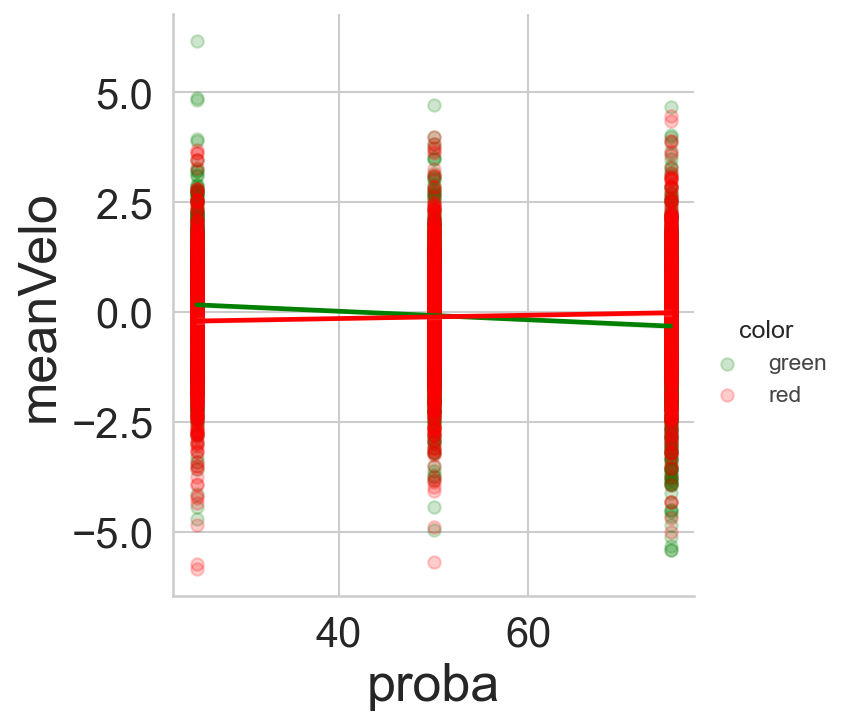

In [2]:
sns.lmplot(
    x="proba",
    y="meanVelo",
    data=df,
    hue="color",
    scatter_kws={"alpha": 0.2},
    palette=colors,
)

In [ ]:
lateTrials = df[df["trial_number"] > 120]

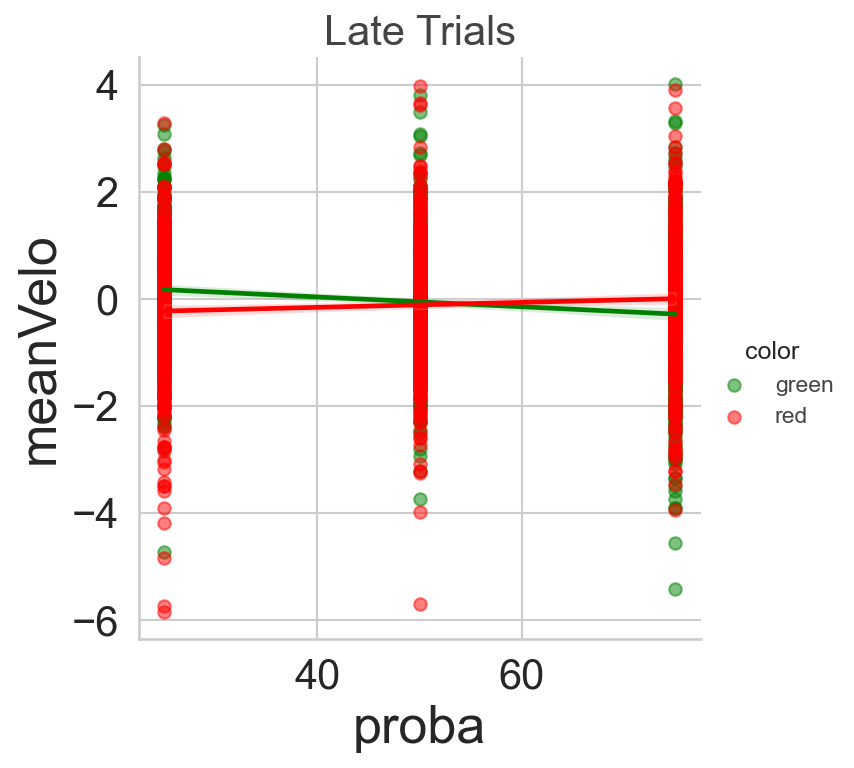

Text(0.5, 1.0, 'Late Trials')

In [3]:
# Set style to whitegrid

sns.lmplot(
    x="proba",
    y="meanVelo",
    data=lateTrials,
    hue="color",
    scatter_kws={"alpha": 0.5},
    palette=colors,
)
plt.title("Late Trials")

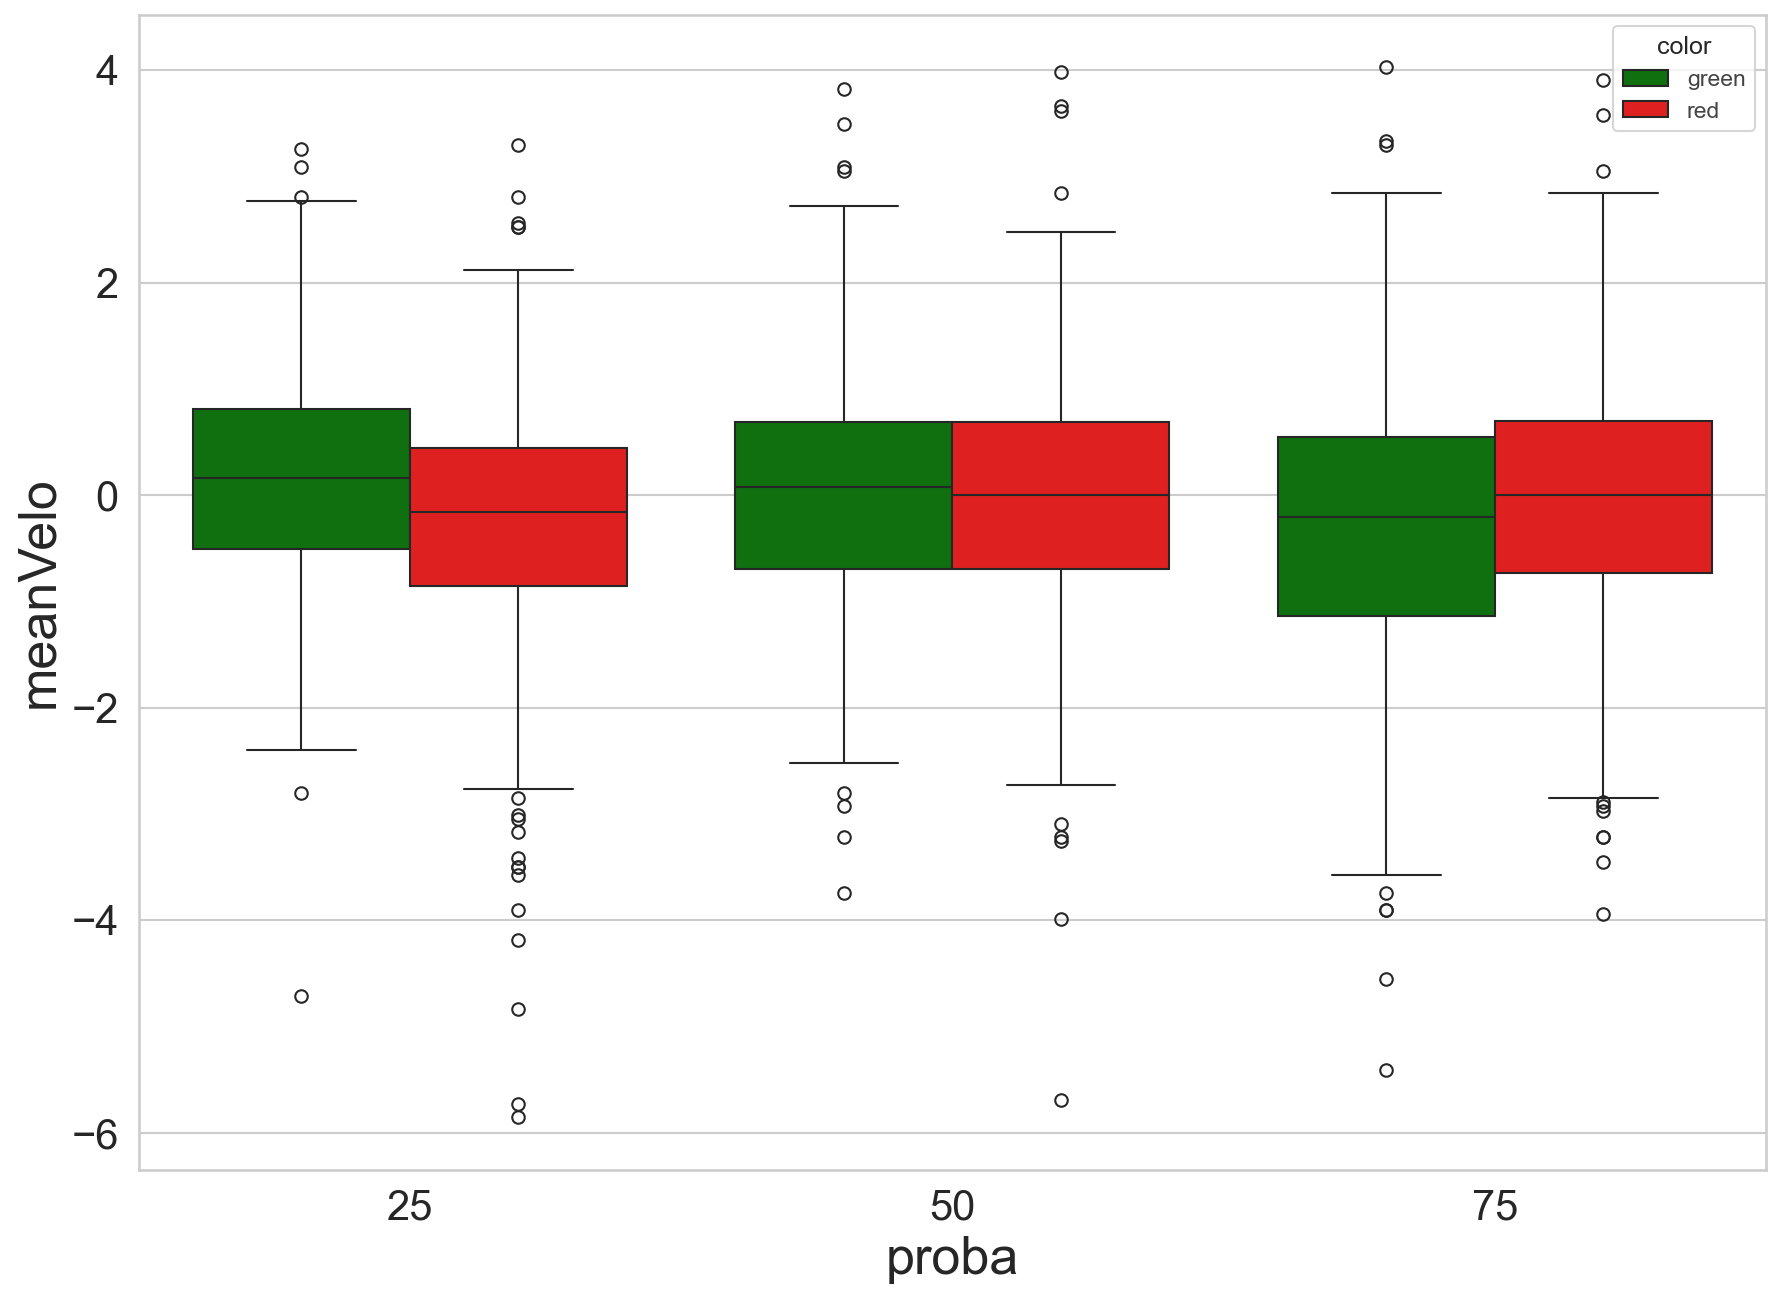

<Axes: xlabel='proba', ylabel='meanVelo'>

In [4]:
sns.boxplot(x="proba", y="meanVelo", hue="color", data=lateTrials, palette=colors)

In [5]:
lateTrials.columns

Index(['onset', 'duration', 'sub_number', 'trial_number', 'trial_color_UP',
       'trial_color_chosen', 'trial_direction', 'trial_RT_colochoice', 'SON',
       'SOFF', 'meanPos', 'stdPos', 'meanVelo', 'stdVelo', 'meanVSS', 'proba',
       'color'],
      dtype='object')

In [6]:
l = (
    df.groupby(["sub_number", "trial_color_chosen", "proba"])
    .meanVelo.mean()
    .reset_index()
)
l

    sub_number  trial_color_chosen  proba  meanVelo
0            1                   0     25  0.020139
1            1                   0     50 -0.113671
2            1                   0     75 -0.774520
3            1                   1     25 -0.277501
4            1                   1     50 -0.072793
..         ...                 ...    ...       ...
91          16                   0     50  0.250124
92          16                   0     75 -0.103474
93          16                   1     25  0.122393
94          16                   1     50 -0.061579
95          16                   1     75 -0.284111

[96 rows x 4 columns]

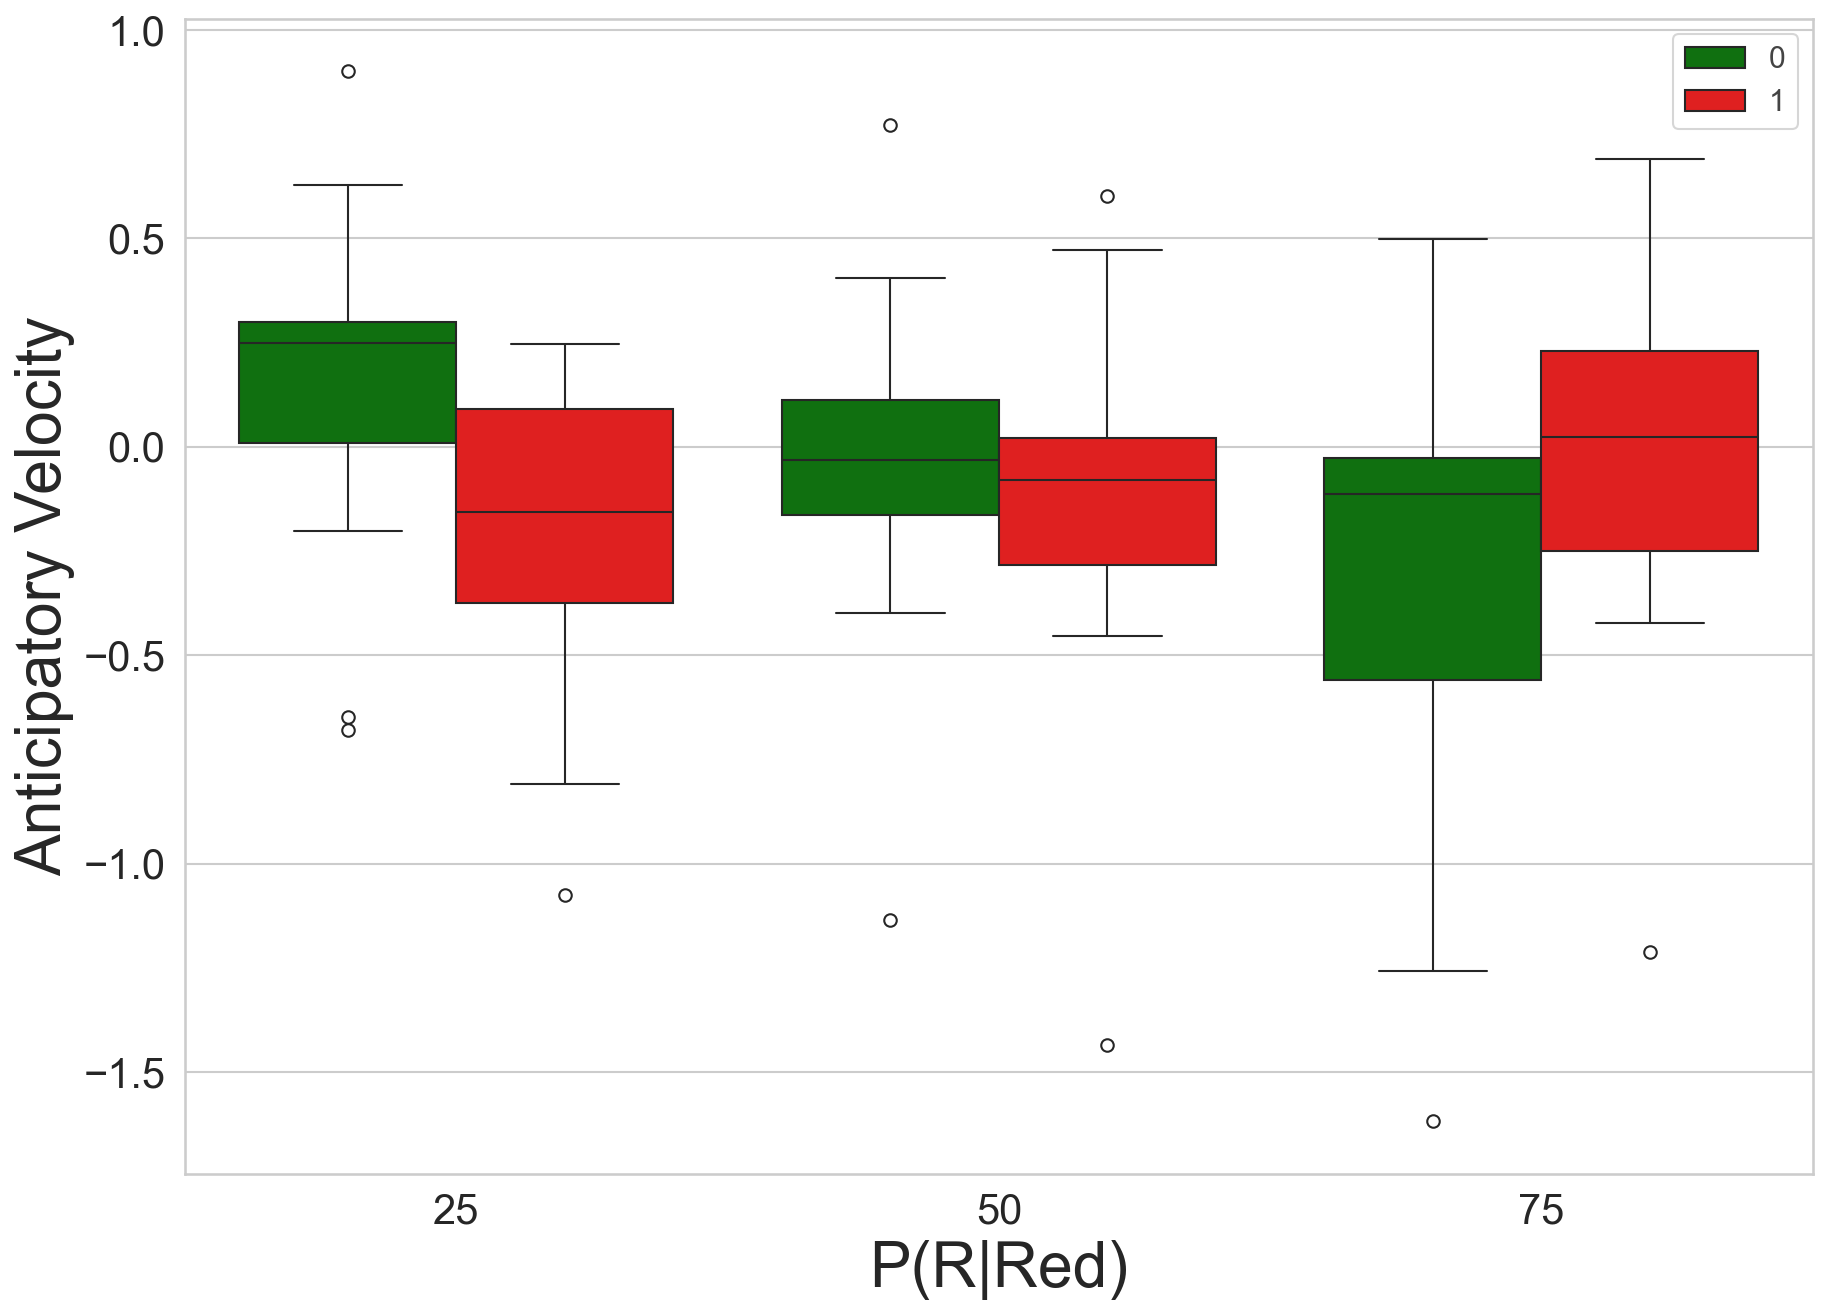

In [7]:
bp = sns.boxplot(
    x="proba", y="meanVelo", hue="trial_color_chosen", data=l, palette=colors
)
bp.legend(fontsize="larger")
plt.xlabel("P(R|Red)", fontsize=30)
plt.ylabel("Anticipatory Velocity", fontsize=30)
plt.savefig("clccbp.png")

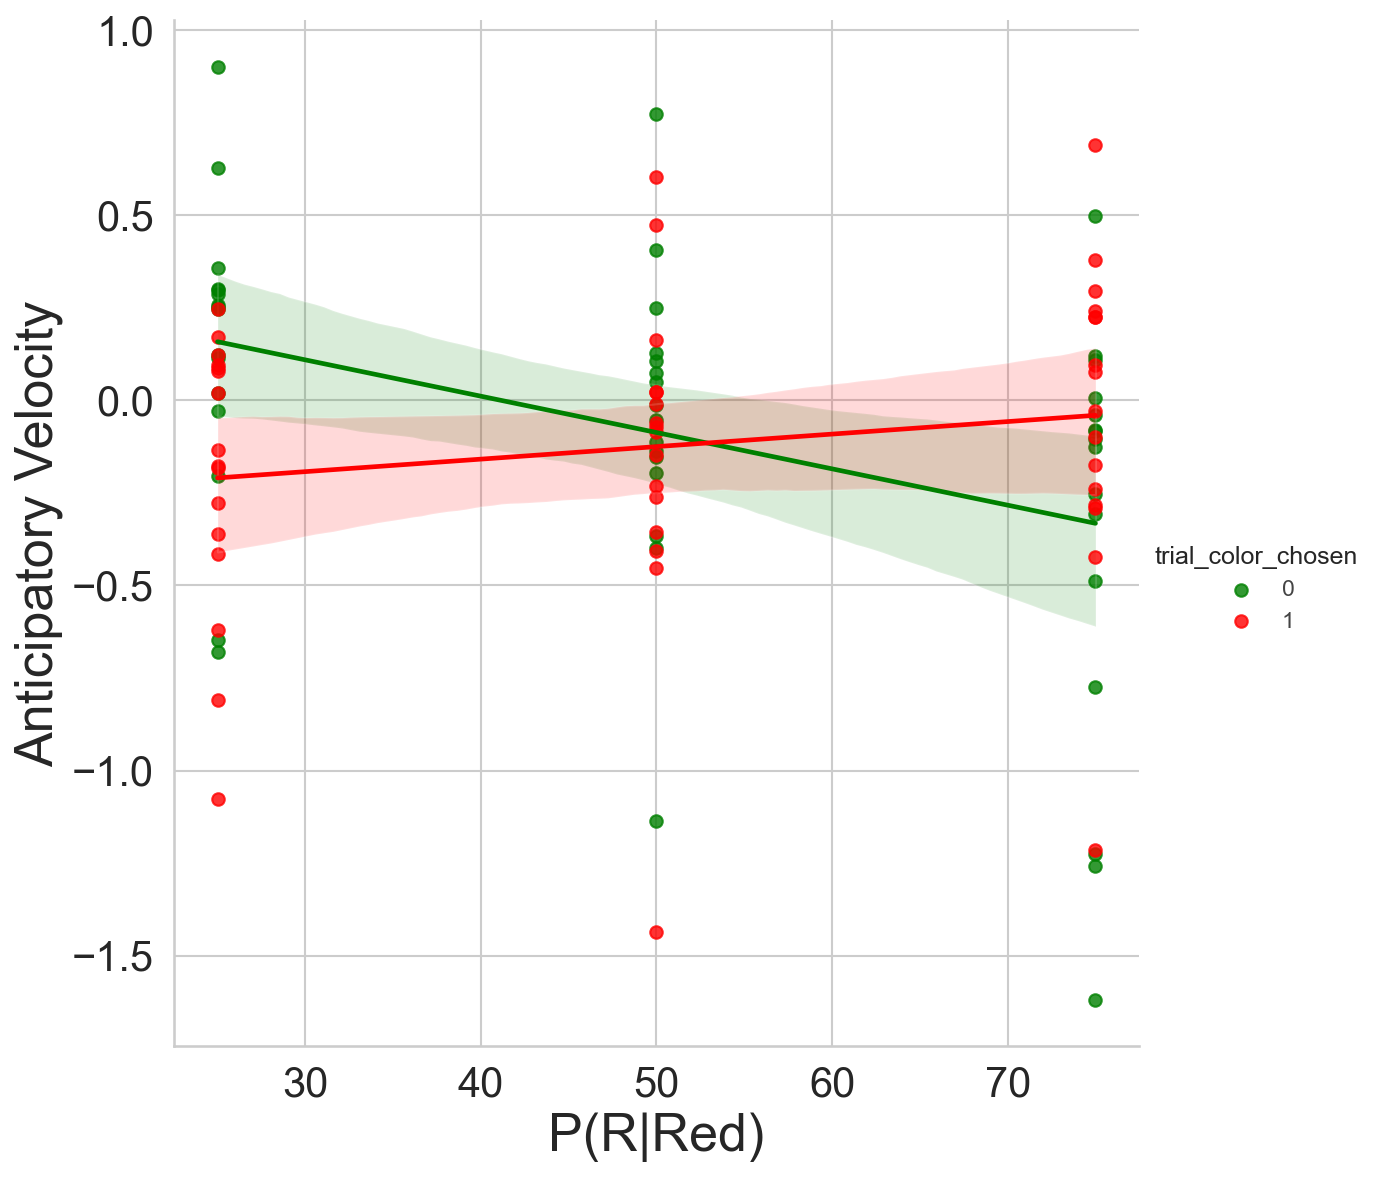

In [8]:
lm = sns.lmplot(
    x="proba", y="meanVelo", hue="trial_color_chosen", data=l, palette=colors, height=8
)
# Adjust font size for axis labels
lm.set_axis_labels("P(R|Red)", "Anticipatory Velocity")
# lm.ax.legend(fontsize='large')
plt.savefig("clcclp.png")

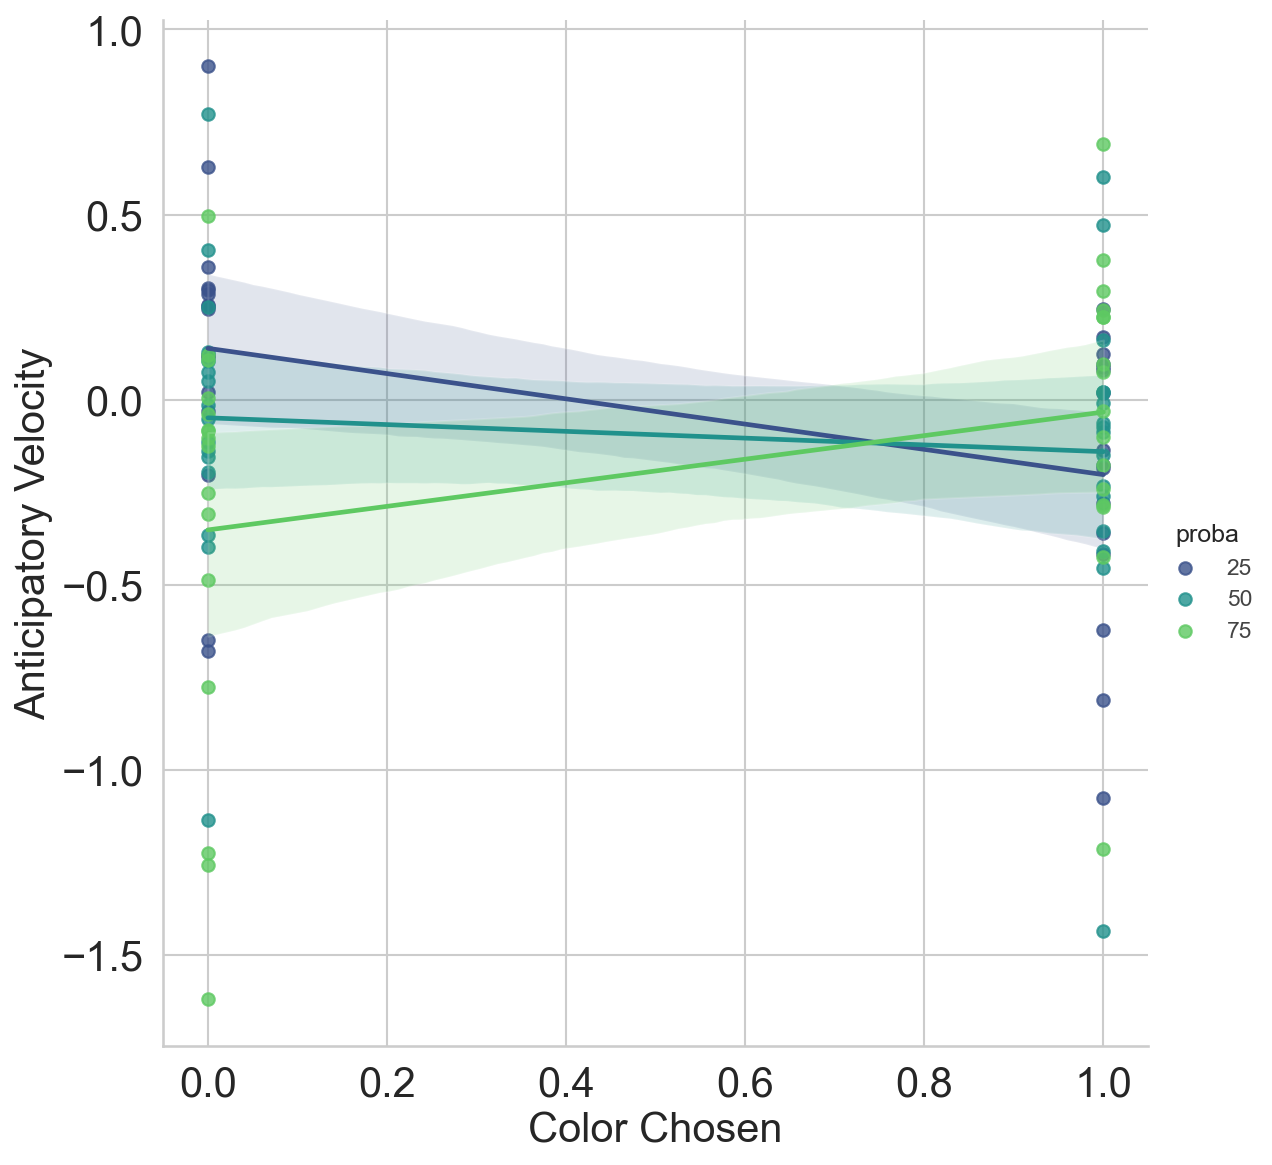

In [9]:
lm = sns.lmplot(
    x="trial_color_chosen",
    y="meanVelo",
    hue="proba",
    data=l,
    height=8,
    palette="viridis",
)
# Adjust font size for axis labels
lm.set_axis_labels("Color Chosen", "Anticipatory Velocity", fontsize=20)

Text(0, 0.5, 'Anticipatory Velocity')


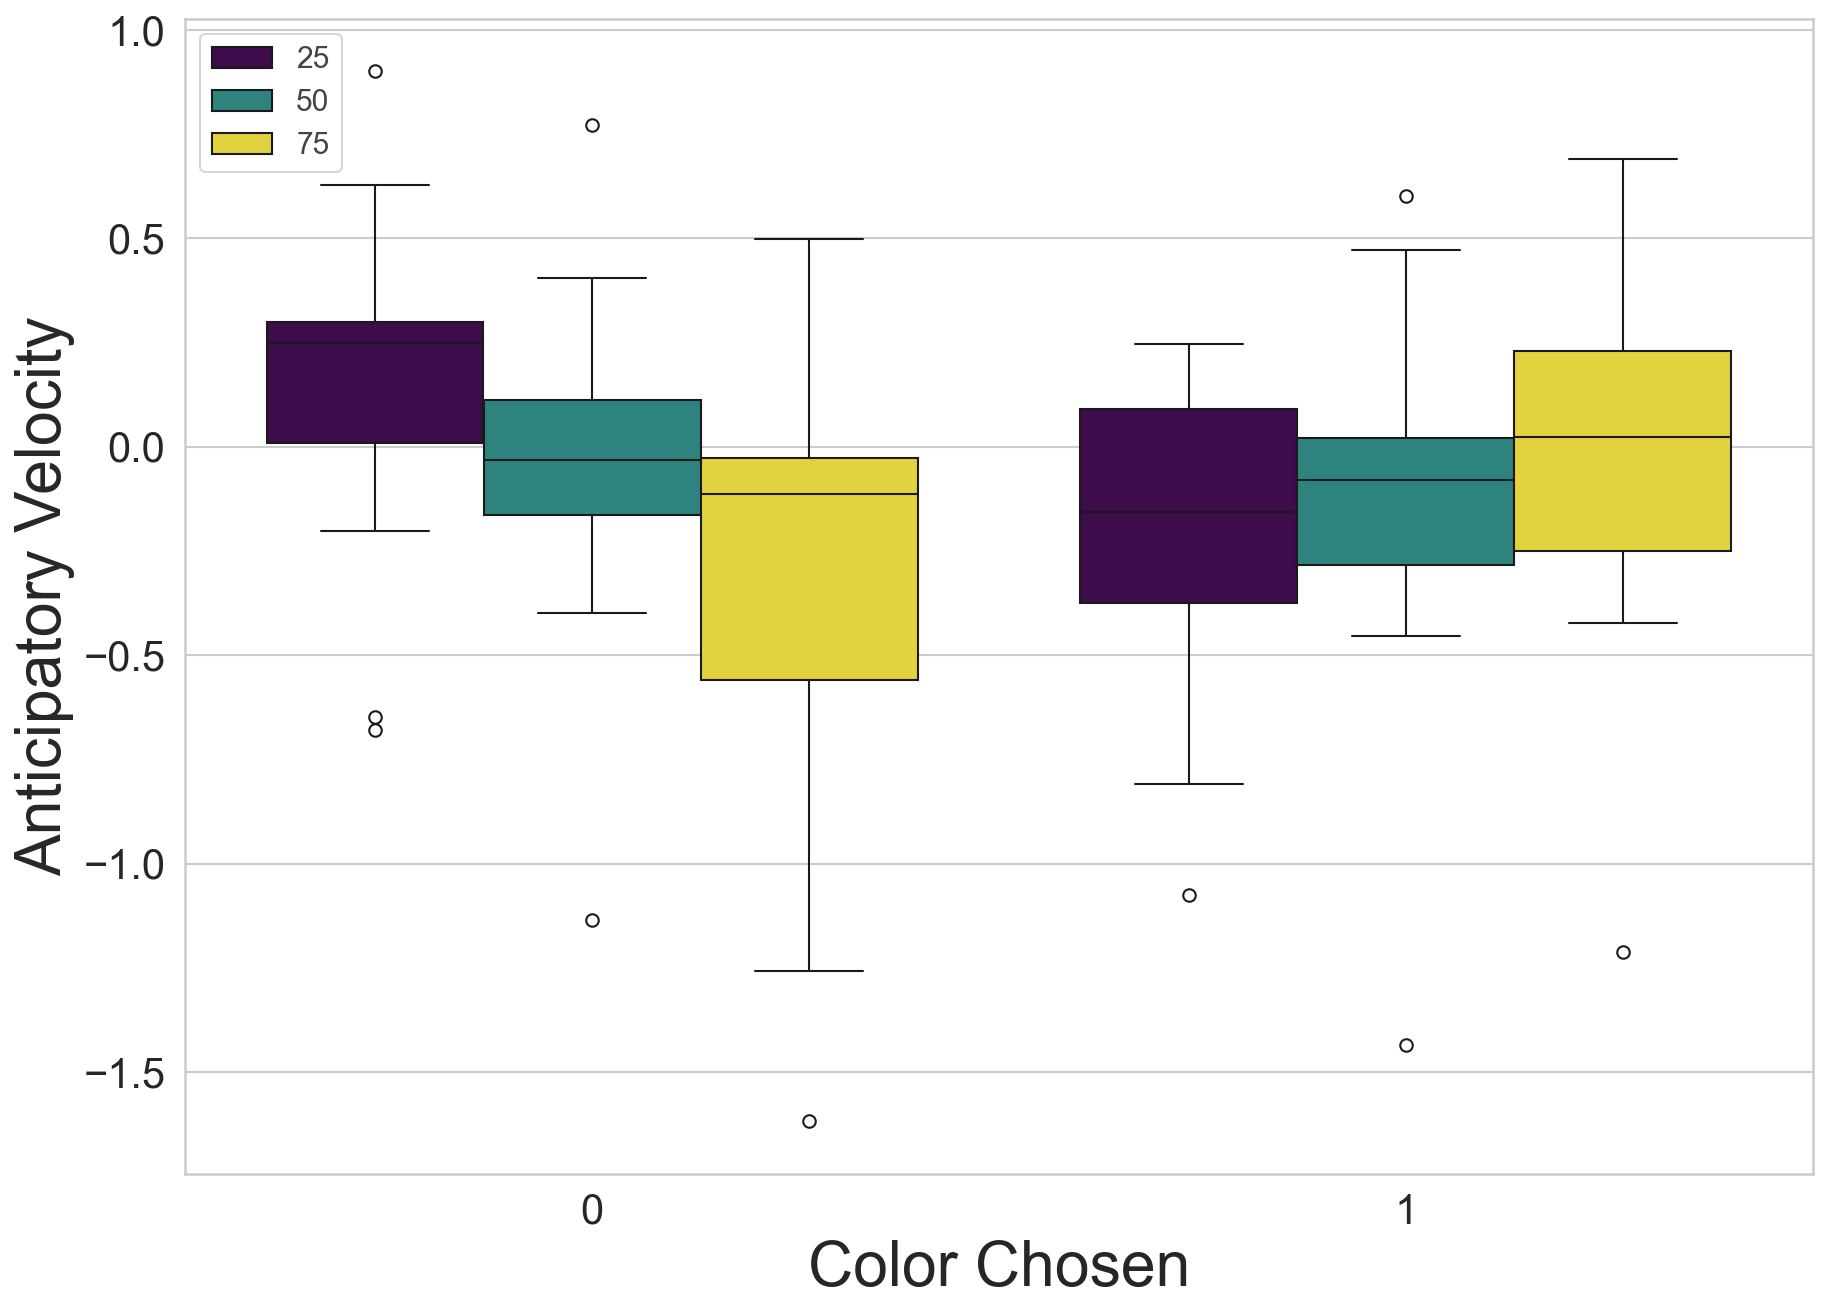

In [10]:
bp = sns.boxplot(
    x="trial_color_chosen",
    y="meanVelo",
    hue="proba",
    data=l,
    palette="viridis",
)

bp.legend(fontsize="larger")
plt.xlabel("Color Chosen", fontsize=30)
plt.ylabel("Anticipatory Velocity", fontsize=30)

In [11]:
df[(df.sub_number == 8)].trial_color_chosen

5040    0
5043    0
5059    0
5066    0
5088    0
       ..
5739    1
5747    1
5752    1
5753    1
5759    1
Name: trial_color_chosen, Length: 168, dtype: int64

In [12]:
model = sm.OLS.from_formula("meanVelo ~ C(proba) ", data=df[df.color == "red"])
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               meanVelo   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.035
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           0.000893
Time:                        15:46:03   Log-Likelihood:                -5234.9
No. Observations:                3307   AIC:                         1.048e+04
Df Residuals:                    3304   BIC:                         1.049e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2060      0.036     -5.

In [13]:
model = sm.OLS.from_formula("meanVelo ~ C(proba) ", data=df[df.color == "green"])
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               meanVelo   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     42.56
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           5.63e-19
Time:                        15:46:27   Log-Likelihood:                -5442.4
No. Observations:                3321   AIC:                         1.089e+04
Df Residuals:                    3318   BIC:                         1.091e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1464      0.038      3.

In [14]:
model = sm.OLS.from_formula("meanVelo ~ C(color) ", data=df[df.proba == 25])
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               meanVelo   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     47.81
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           6.16e-12
Time:                        15:46:50   Log-Likelihood:                -3439.9
No. Observations:                2165   AIC:                             6884.
Df Residuals:                    2163   BIC:                             6895.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1464      0.036     

In [15]:
model = sm.OLS.from_formula("meanVelo ~ C(color) ", data=df[df.proba == 75])
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               meanVelo   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     33.96
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           6.44e-09
Time:                        15:47:03   Log-Likelihood:                -3690.3
No. Observations:                2202   AIC:                             7385.
Df Residuals:                    2200   BIC:                             7396.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.3382      0.039     

In [16]:
model = sm.OLS.from_formula("meanVelo ~ C(color) ", data=df[df.proba == 50])
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               meanVelo   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.659
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.198
Time:                        15:47:07   Log-Likelihood:                -3536.8
No. Observations:                2261   AIC:                             7078.
Df Residuals:                    2259   BIC:                             7089.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0335      0.035     

In [17]:
model = ols("meanVelo ~ C(proba) ", data=df[df.trial_color_chosen == 1]).fit()
anova_table = sm.stats.anova_lm(model, typ=3)

print(anova_table)

                sum_sq      df          F        PR(>F)
Intercept    45.830746     1.0  32.981429  1.014672e-08
C(proba)     19.552786     2.0   7.035439  8.933787e-04
Residual   4591.213605  3304.0        NaN           NaN


In [18]:
rp.summary_cont(df.groupby(["sub_number", "color", "proba"])["meanVelo"])

                          N    Mean      SD      SE  95% Conf.  Interval
sub_number color proba                                                  
1          green 25     109  0.0201  1.0066  0.0964    -0.1710    0.2113
                 50     108 -0.1137  1.0972  0.1056    -0.3230    0.0956
                 75      94 -0.7745  1.2791  0.1319    -1.0365   -0.5125
           red   25      98 -0.2775  1.0173  0.1028    -0.4814   -0.0736
                 50      86 -0.0728  1.0512  0.1134    -0.2982    0.1526
...                     ...     ...     ...     ...        ...       ...
16         green 50      98  0.2501  1.0980  0.1109     0.0300    0.4703
                 75      99 -0.1035  1.2388  0.1245    -0.3506    0.1436
           red   25      92  0.1224  1.2070  0.1258    -0.1276    0.3723
                 50     101 -0.0616  1.0565  0.1051    -0.2701    0.1470
                 75      92 -0.2841  1.1278  0.1176    -0.5177   -0.0505

[96 rows x 6 columns]

In [19]:
model = ols("meanVelo ~ C(proba):C(color) ", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)

print(anova_table)

                        sum_sq      df          F        PR(>F)
Intercept            23.259970     1.0  15.803754  7.101038e-05
C(proba):C(color)   153.194960     5.0  20.817357  1.064357e-20
Residual           9746.261739  6622.0        NaN           NaN


In [20]:
model = smf.mixedlm(
    "meanVelo ~ C(color)*C(proba)",
    data=df,
    groups=df["sub_number"],
).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      meanVelo   
No. Observations:       6628         Method:                  REML       
No. Groups:             16           Scale:                   1.3746     
Min. group size:        121          Log-Likelihood:          -10498.1883
Max. group size:        599          Converged:               Yes        
Mean group size:        414.2                                            
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.100    0.101  0.991 0.322 -0.098  0.297
C(color)[T.red]                -0.345    0.050 -6.848 0.000 -0.444 -0.247
C(proba)[T.50]                 -0.151    0.050 -3.005 0.003 -0.249 -0.052
C(proba

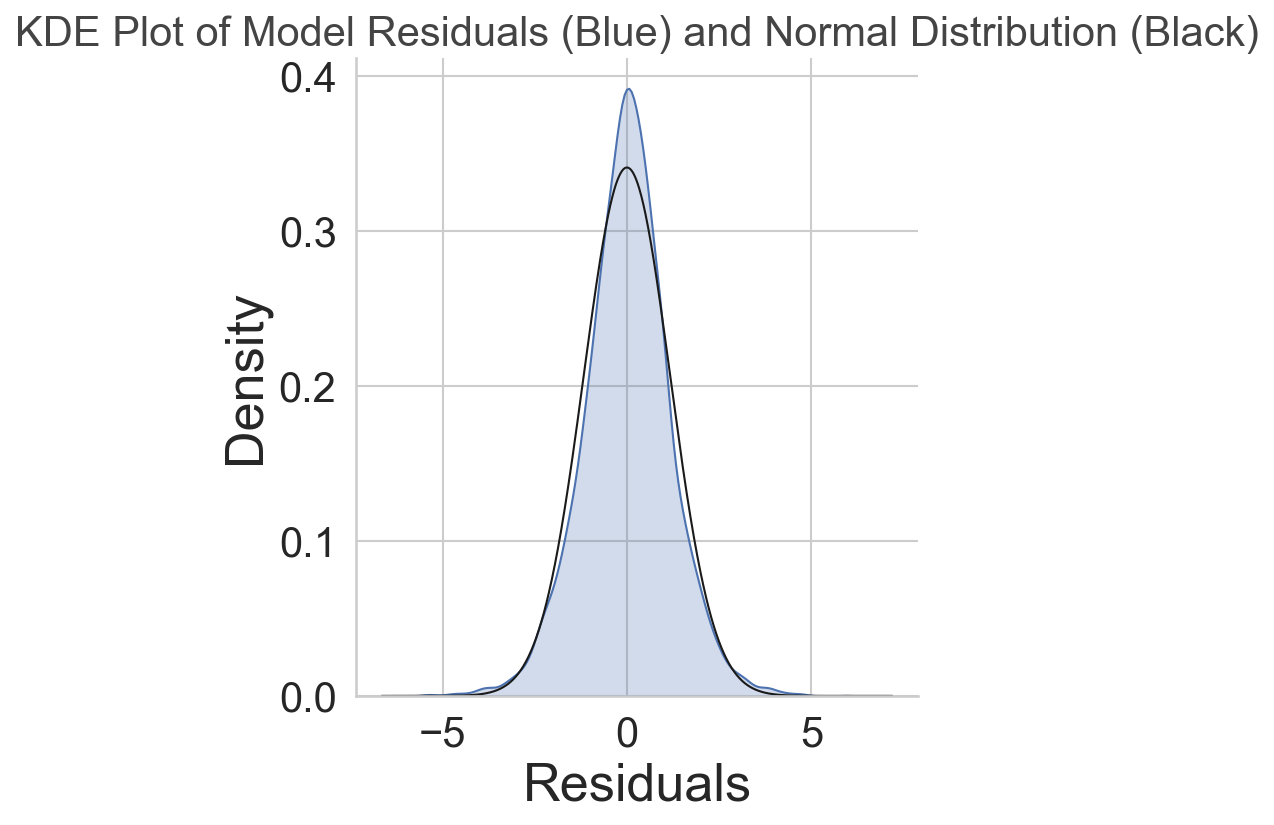

Text(0.5, 24.888888888888875, 'Residuals')

In [21]:
# Create a KDE plot of residuals
sns.displot(model.resid, kind="kde", fill=True, lw=1)

# Overlay normal distribution on the same plot
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = stats.norm.pdf(x, np.mean(model.resid), np.std(model.resid))
plt.plot(x, p, "k", linewidth=1)

# Set title and labels
plt.title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
plt.xlabel("Residuals")

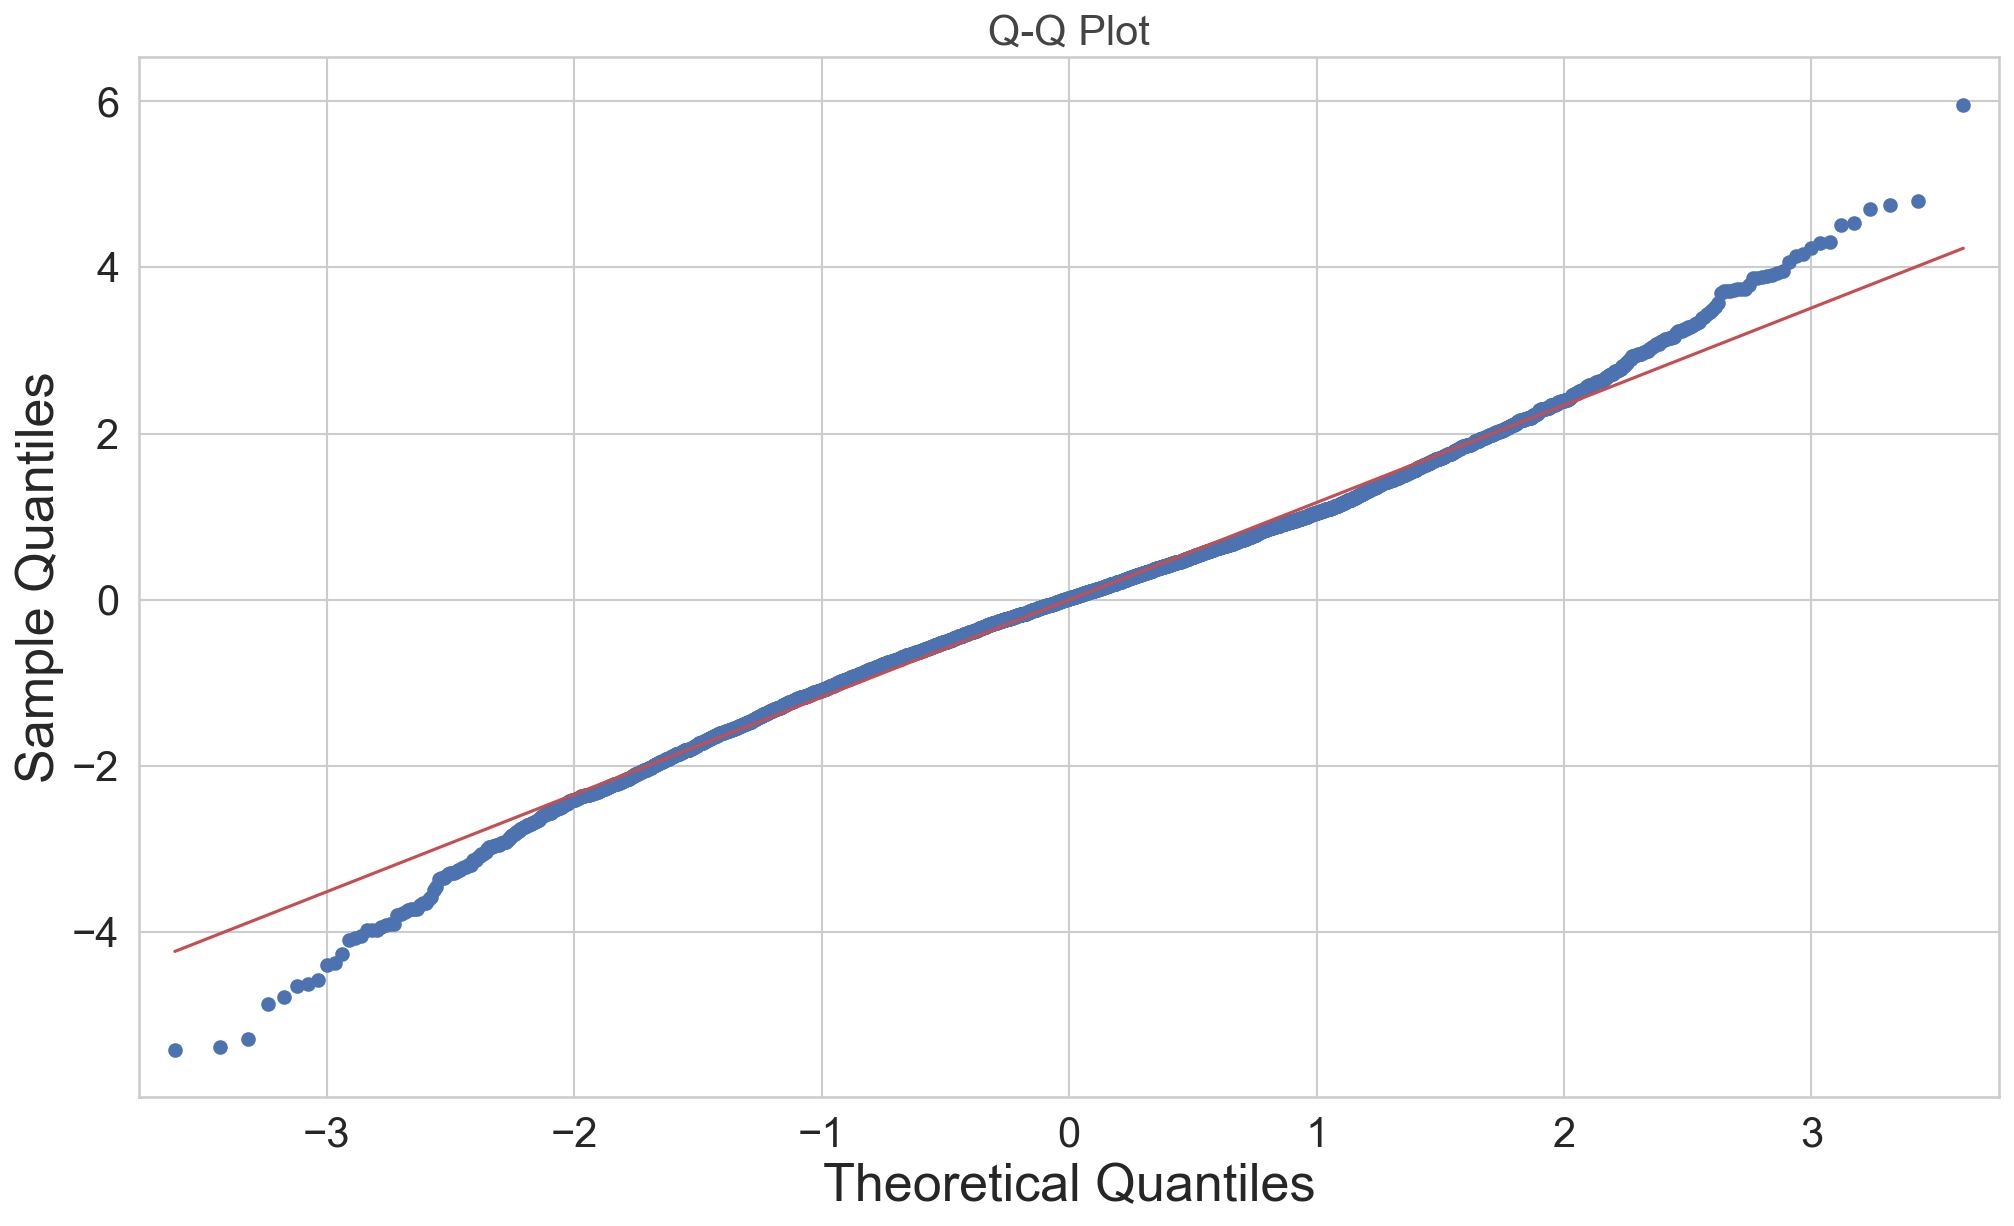

Text(0.5, 1.0, 'Q-Q Plot')

In [22]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

sm.qqplot(model.resid, dist=stats.norm, line="s", ax=ax)

ax.set_title("Q-Q Plot")

In [23]:
labels = ["Statistic", "p-value"]

norm_res = stats.normaltest(model.resid)

for key, val in dict(zip(labels, norm_res)).items():
    print(key, val)

Statistic 156.21863423123193
p-value 1.1955137940757912e-34


Text(0.5, 0, 'Subject')


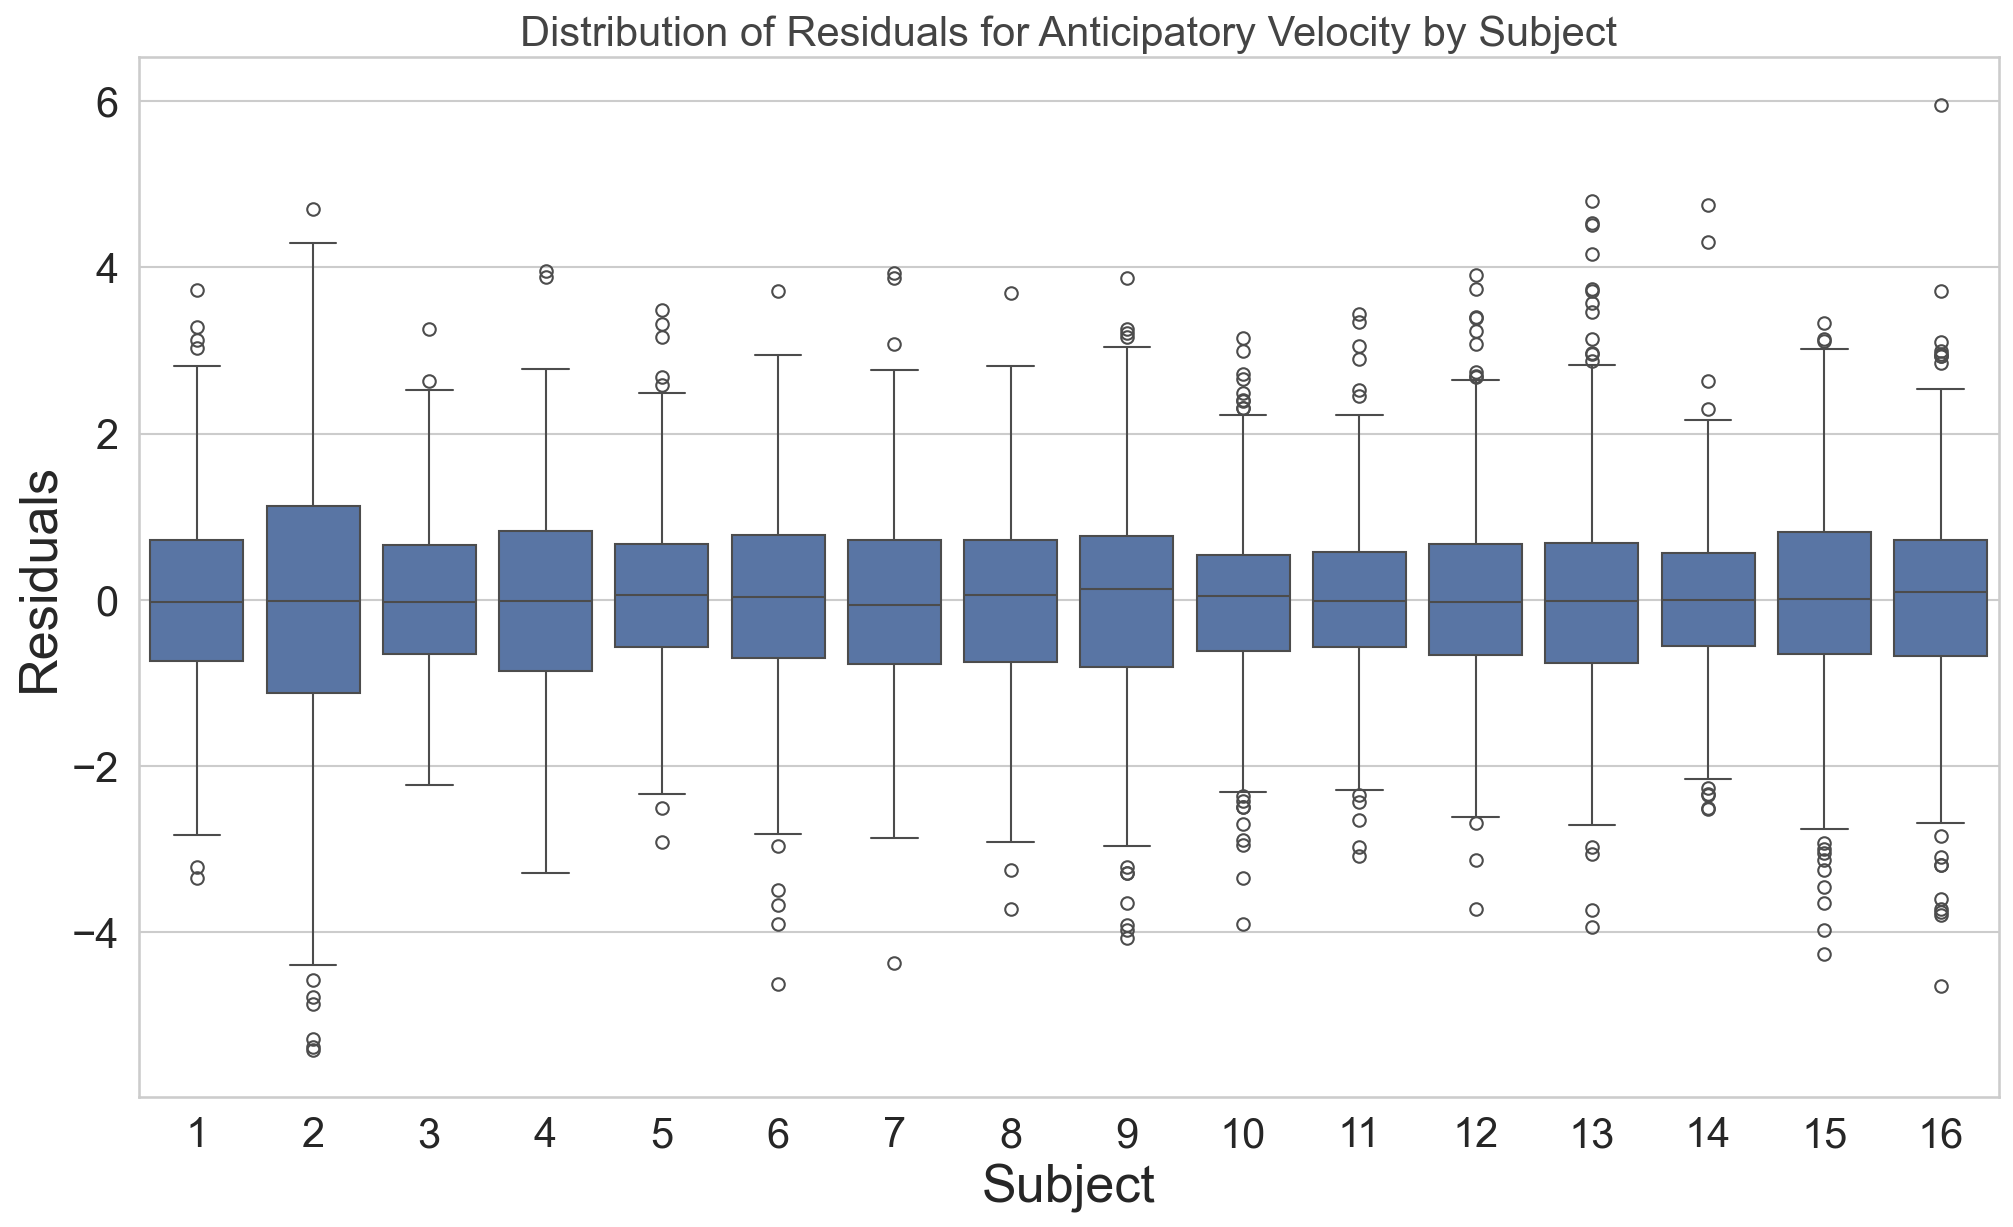

In [24]:
fig = plt.figure(figsize=(16, 9))

ax = sns.boxplot(x=model.model.groups, y=model.resid)

ax.set_title("Distribution of Residuals for Anticipatory Velocity by Subject")
ax.set_ylabel("Residuals")
ax.set_xlabel("Subject")

In [25]:
het_white_res = het_white(model.resid, model.model.exog)

labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

for key, val in dict(zip(labels, het_white_res)).items():
    print(key, val)

LM Statistic 22.19968658124492
LM-Test p-value 0.00047975191006204904
F-Statistic 4.450825564387161
F-Test p-value 0.0004751150155673094


In [26]:
# t test to comprare proba 25/red and proba75/green
stats.ttest_ind(
    df[(df.proba == 25) & (df.color == "red")].meanVelo,
    df[(df.proba == 75) & (df.color == "green")].meanVelo,
)

TtestResult(statistic=2.4092805223101403, pvalue=0.01606601477723909, df=2191.0)

In [27]:
# Example assuming 'proba' and 'color' are categorical variables in your DataFrame
colors = df["color"].unique()

for color in colors:
    # Filter data for the current color
    color_data = df[df["color"] == color]

    # Group data by 'proba' and get meanVelo for each group
    grouped_data = [group["meanVelo"] for proba, group in color_data.groupby("proba")]

    # Perform Kruskal-Wallis test
    statistic, p_value = kruskal(*grouped_data)

    # Print results for each color
    print(f"Color: {color}")
    print(f"Kruskal-Wallis Statistic: {statistic}")
    print(f"P-value: {p_value}")

    # Check if the result is statistically significant
    if p_value < 0.01:
        print(
            "The probabilities within this color have significantly different distributions."
        )
    else:
        print(
            "There is not enough evidence to suggest significant differences between probabilities within this color."
        )
    print("\n")

Color: green
Kruskal-Wallis Statistic: 70.1442064600344
P-value: 5.866500316826155e-16
The probabilities within this color have significantly different distributions.


Color: red
Kruskal-Wallis Statistic: 14.162356724363889
P-value: 0.0008407818189220024
The probabilities within this color have significantly different distributions.




In [ ]:
# Analsis of subject who did Vanessa's task
df_prime = df[df.sub_number > 12]

In [28]:
l_prime = (
    df_prime.groupby(["sub_number", "trial_color_chosen", "proba"])
    .meanVelo.mean()
    .reset_index()
)
l_prime

    sub_number  trial_color_chosen  proba  meanVelo
0           13                   0     25  0.297601
1           13                   0     50  0.105860
2           13                   0     75  0.108263
3           13                   1     25  0.079814
4           13                   1     50  0.021823
5           13                   1     75  0.096154
6           14                   0     25  0.286606
7           14                   0     50 -0.196401
8           14                   0     75 -0.125339
9           14                   1     25 -0.184016
10          14                   1     50 -0.260242
11          14                   1     75 -0.029754
12          15                   0     25 -0.648238
13          15                   0     50 -0.398481
14          15                   0     75 -1.618512
15          15                   1     25 -0.415699
16          15                   1     50 -0.454095
17          15                   1     75 -0.239837
18          

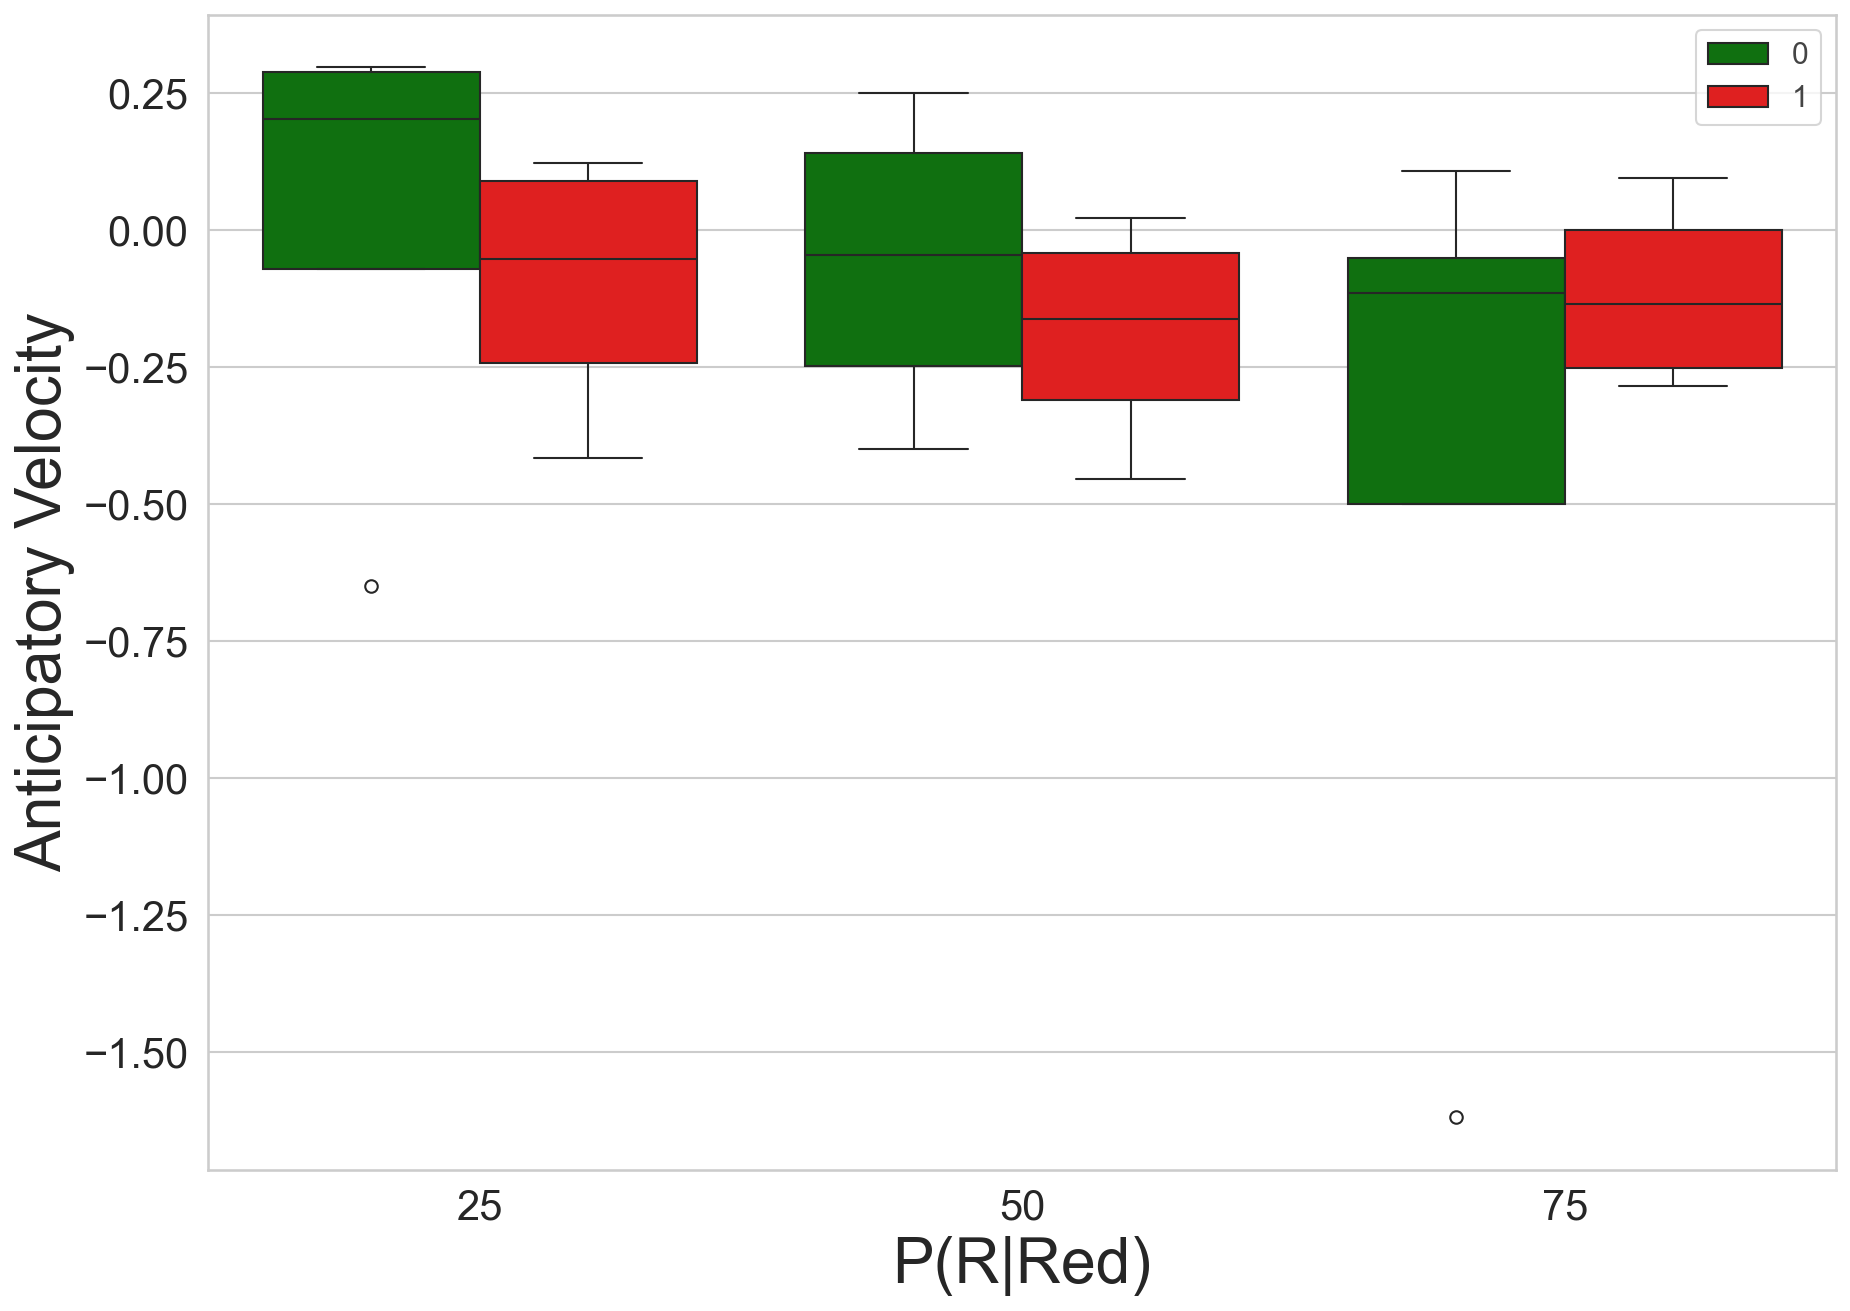

In [29]:
bp = sns.boxplot(
    x="proba", y="meanVelo", hue="trial_color_chosen", data=l_prime, palette=colors
)
bp.legend(fontsize="larger")
plt.xlabel("P(R|Red)", fontsize=30)
plt.ylabel("Anticipatory Velocity", fontsize=30)
plt.savefig("clccbp.png")

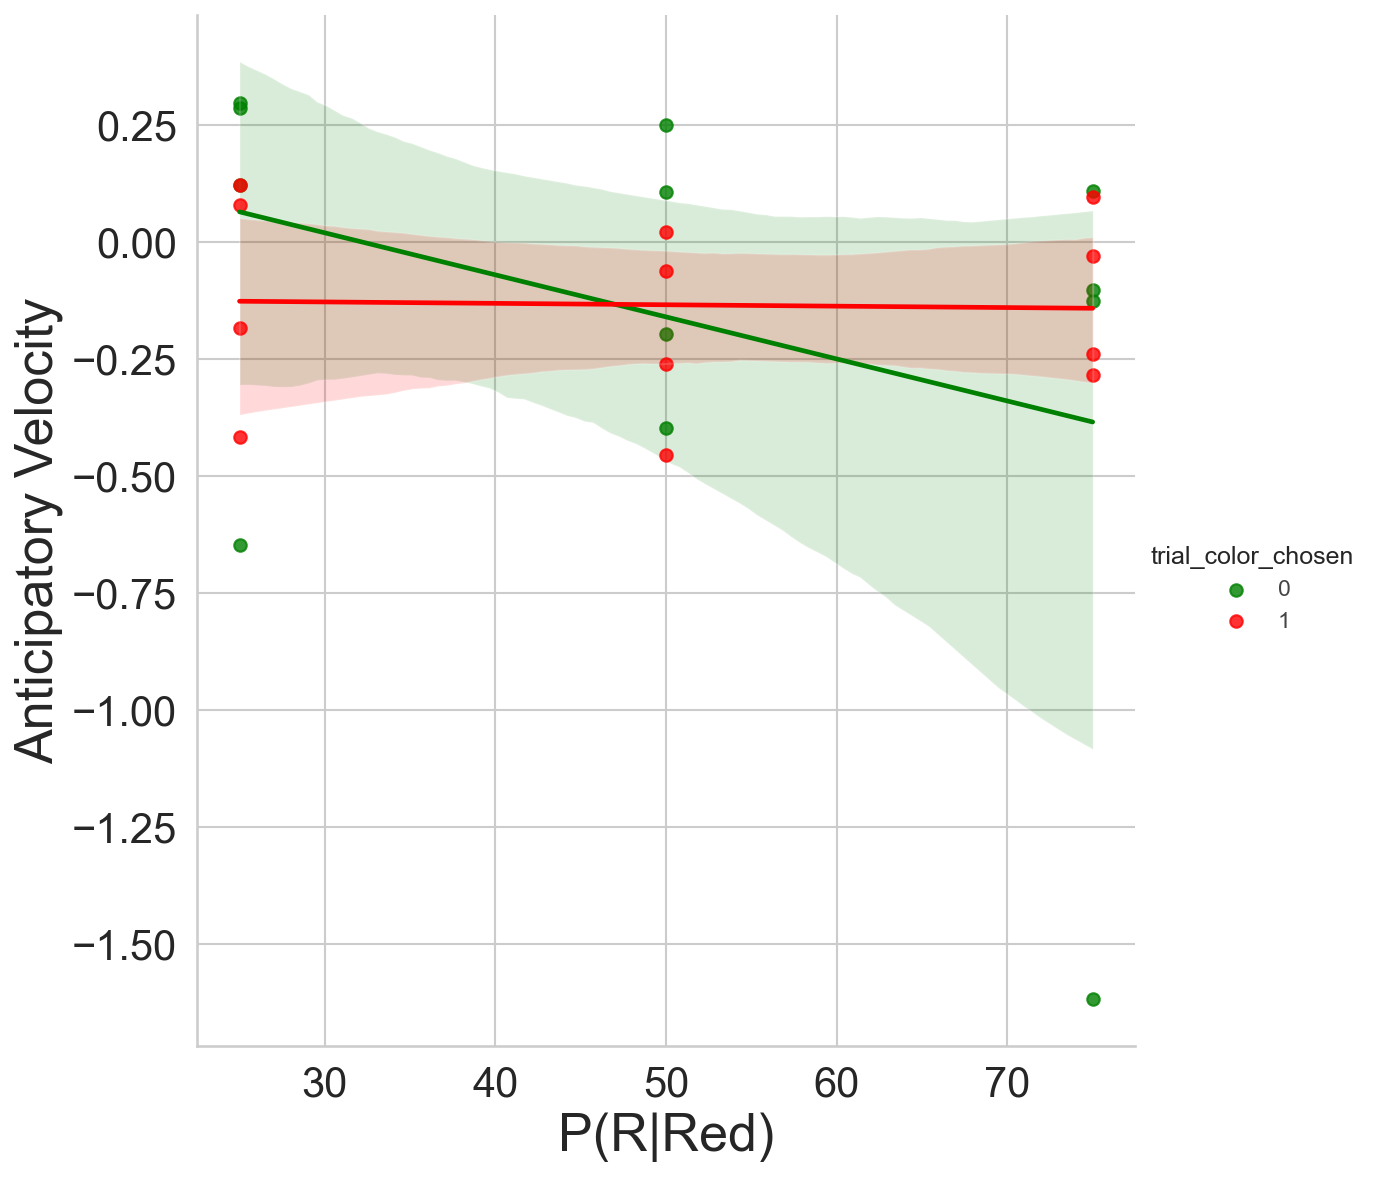

In [30]:
lm = sns.lmplot(
    x="proba", y="meanVelo", hue="trial_color_chosen", data=l_prime, palette=colors, height=8
)
# Adjust font size for axis labels
lm.set_axis_labels("P(R|Red)", "Anticipatory Velocity")